<a href="https://colab.research.google.com/github/Fildo7525/SDU-DNN/blob/master/08_autoencoder_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Denoising Auto Encoder



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch
from torch import nn
from torch.nn import functional as F
import torchvision
from tqdm.notebook import tqdm
from scipy import ndimage
# from google_drive_downloader import GoogleDriveDownloader as gdd

## Load FaceScrub data

In [ ]:
# gdd.download_file_from_google_drive('1Uzgc9c0MSYP4y9ia7mvwCGggjhTDEmrk', '~/img_align_celeba_50k.npz')
!gdown 'https://drive.google.com/uc?id=1Uzgc9c0MSYP4y9ia7mvwCGggjhTDEmrk'
blob = np.load('/content/img_align_celeba_50k.npz')
x_train, x_test = blob['x_train'], blob['x_test']
dim = x_train.shape[1:]
n_valid = 2000
x_train, x_valid = x_train[:-n_valid], x_train[-n_valid:]

print(f'x_train shape: {x_train.shape}')
print(f'x_valid shape: {x_valid.shape}')
print(f'dtype: {x_train.dtype}')

x_train shape: (48000, 32, 32, 3)
x_valid shape: (2000, 32, 32, 3)
dtype: float32


Corrupt input: x_corrupted = g(x)  
Estimate original: x_hat = f(g(x))

g should be your noise model e.g. gaussian blur (refer opencv Gaussian blue)

In [ ]:
x_train_blur = np.empty_like(x_train)
for i in tqdm(range(len(x_train))):
    x_train_blur[i] = cv2.GaussianBlur(x_train[i], (3, 3), 1)

x_valid_blur = np.empty_like(x_valid)
for i in tqdm(range(len(x_valid))):
    x_valid_blur[i] = cv2.GaussianBlur(x_valid[i], (3, 3), 1)

  0%|          | 0/48000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

## Now lets visualize our original and corrupted data

In [ ]:
def plot_rows(*img_rows, scale=1.):
    rows = len(img_rows)
    cols = len(img_rows[0])
    fig, axs = plt.subplots(rows, cols, figsize=(cols * scale, rows * scale))
    for i, img_row in enumerate(img_rows):
        for j, im in enumerate(img_row):
            ax = axs[i, j]
            ax.imshow(np.clip(im, 0, 1))
            ax.axis('off')
    plt.tight_layout()
    plt.show()

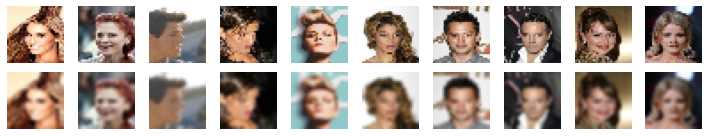

In [ ]:
plot_rows(x_train[:10], x_train_blur[:10])

## Normalizing the data

In [ ]:
mu, std = np.mean(x_train, axis=(0, 1, 2)), np.std(x_train, axis=(0, 1, 2))
print("mu: ", mu, " sigma: ", std)

def norm(a):
    return torch.from_numpy((a - mu) / std).permute(0, 3, 1, 2)

def denorm(a):
    return a.detach().cpu().permute(0, 2, 3, 1).numpy() * std + mu

x_train_normed = norm(x_train)
x_valid_normed = norm(x_valid)
x_train_blur_normed = norm(x_train_blur)
x_valid_blur_normed = norm(x_valid_blur)

mu:  [0.34133333 0.34133333 0.34133333]  sigma:  [0.32654327 0.27426648 0.2628333 ]


## Now build you de-nosing auto-encoder model

Tip:
* Its better to use over-complete auto-encoder (i.e latent represent is of higher dimensionality than the input)
* You will need to use trasnposed convolution in decoder (check torch ConvTranspose2d)
* You can start with 2 convolutioanl layers each for encoder & decoder

In [ ]:
# note that this Auto Encoder is overcomplete:
#   the latent representation in the middle is of higher dimensionality than the input
def build_model():
    return nn.Sequential(
        nn.Conv2d(3, 16, 3), nn.ReLU(True),
        nn.Conv2d(16, 64, 3), nn.ReLU(True),
        nn.ConvTranspose2d(64, 64, 3), nn.ReLU(True),
        nn.ConvTranspose2d(64, 16, 3), nn.ReLU(True),
        nn.Conv2d(16, 3, 1, 1)
    )

## Loading data for training

In [ ]:
train_data = list(zip(x_train_blur_normed, x_train_normed))
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True, num_workers=4)

valid_data = list(zip(x_valid_blur_normed, x_valid_normed))
valid_dataloader = torch.utils.data.DataLoader(valid_data, batch_size=128, shuffle=True, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Now lets train the auto-encoder

  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch: 0, mse loss (train/valid): 0.1427/0.0645
Row wise: blurred (input), reconstructed (output), original (gt). (on validation set)


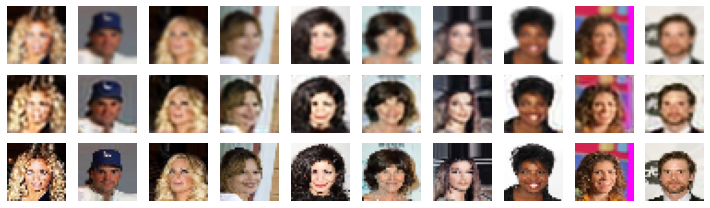

epoch: 1, mse loss (train/valid): 0.0556/0.0503
Row wise: blurred (input), reconstructed (output), original (gt). (on validation set)


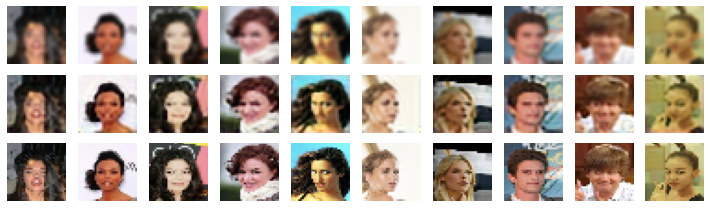

epoch: 2, mse loss (train/valid): 0.0453/0.0420
Row wise: blurred (input), reconstructed (output), original (gt). (on validation set)


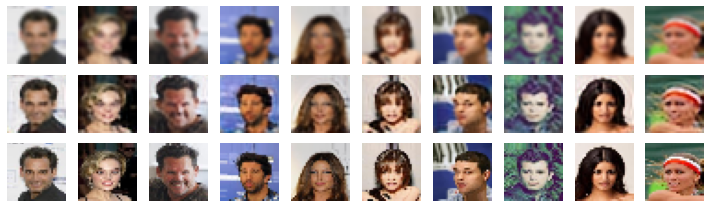

epoch: 3, mse loss (train/valid): 0.0398/0.0392
Row wise: blurred (input), reconstructed (output), original (gt). (on validation set)


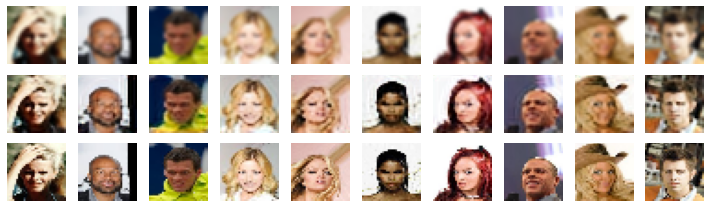

epoch: 4, mse loss (train/valid): 0.0365/0.0355
Row wise: blurred (input), reconstructed (output), original (gt). (on validation set)


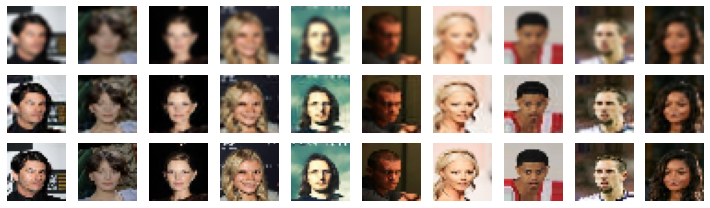

epoch: 5, mse loss (train/valid): 0.0340/0.0335
Row wise: blurred (input), reconstructed (output), original (gt). (on validation set)


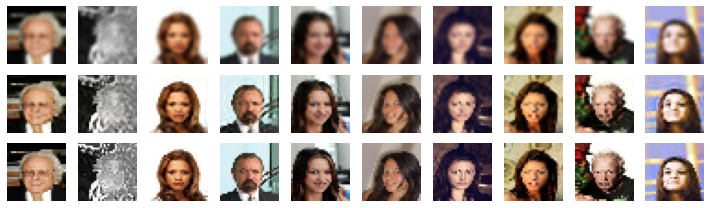

epoch: 6, mse loss (train/valid): 0.0321/0.0315
Row wise: blurred (input), reconstructed (output), original (gt). (on validation set)


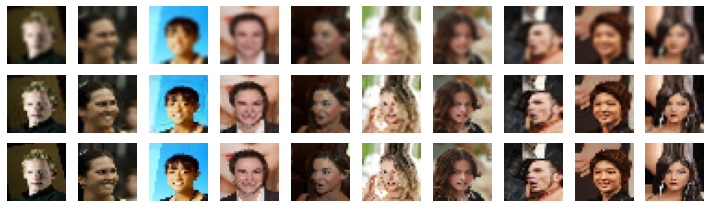

epoch: 7, mse loss (train/valid): 0.0308/0.0306
Row wise: blurred (input), reconstructed (output), original (gt). (on validation set)


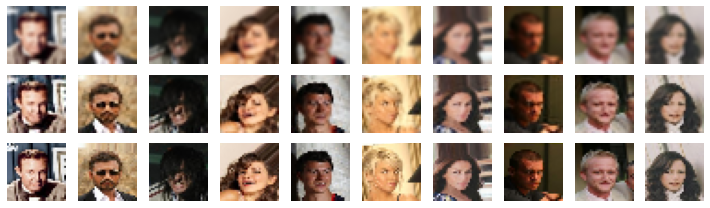

epoch: 8, mse loss (train/valid): 0.0301/0.0296
Row wise: blurred (input), reconstructed (output), original (gt). (on validation set)


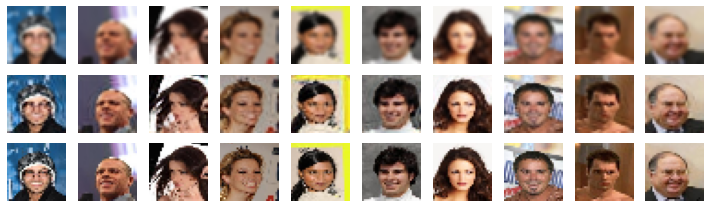

epoch: 9, mse loss (train/valid): 0.0289/0.0287
Row wise: blurred (input), reconstructed (output), original (gt). (on validation set)


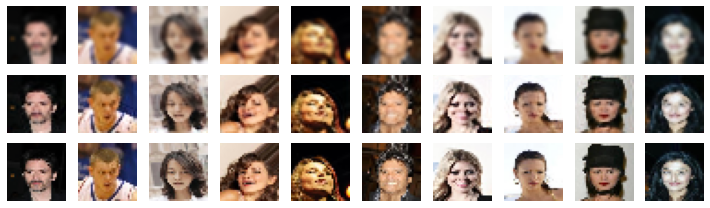

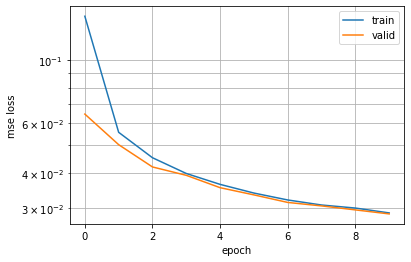

In [ ]:
model = build_model().cuda()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

train_losses = []
valid_losses = []

for epoch in tqdm(range(10)):
    losses = []
    for x, y in train_dataloader:
        x, y = x.cuda(), y.cuda()
        y_hat = model(x)
        loss = F.mse_loss(y_hat, y)

        opt.zero_grad()
        loss.backward()
        opt.step()
        losses.append(loss.item())
    train_losses.append(np.mean(losses))

    losses = []
    for x, y in valid_dataloader:
        x, y = x.cuda(), y.cuda()
        y_hat = model(x)
        loss = F.mse_loss(y_hat, y)
        losses.append(loss.item())
    valid_losses.append(np.mean(losses))

    print(f'epoch: {epoch}, mse loss (train/valid): {train_losses[-1]:.4f}/{valid_losses[-1]:.4f}')
    print('Row wise: blurred (input), reconstructed (output), original (gt). (on validation set)')
    plot_rows(denorm(x[:10]), denorm(y_hat[:10]), denorm(y[:10]), scale=1)

plt.plot(train_losses, label='train')
plt.plot(valid_losses, label='valid')
plt.ylabel('mse loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.grid(which='both')
plt.legend()
plt.show()

# Bonus: Variational Auto Encoder


## Load MNIST data

In [ ]:
mnist = torchvision.datasets.MNIST('~/data', download=True)
print(mnist.data.shape)
print(mnist.targets.shape)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /root/data/MNIST/raw/train-images-idx3-ubyte.gz to /root/data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /root/data/MNIST/raw/train-labels-idx1-ubyte.gz to /root/data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /root/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /root/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/data/MNIST/raw

torch.Size([60000, 28, 28])
torch.Size([60000])


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Normalize data

In [ ]:
data = mnist.data.view(-1, 28 * 28).float() / 255
mu, std = data.mean(), data.std()
data = (data - mu) / std

## Load data

In [ ]:
dataloader = torch.utils.data.DataLoader(data, batch_size=128, shuffle=True, num_workers=4)
dataloader_no_shuffle = torch.utils.data.DataLoader(data, batch_size=128, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Let's first visualize the pca embeddings.
(Reproducing figure 3A in [Reducing the Dimensionality of Data with Neural Networks](https://www.cs.toronto.edu/~hinton/science.pdf), axes may be flipped)

(60000, 2)


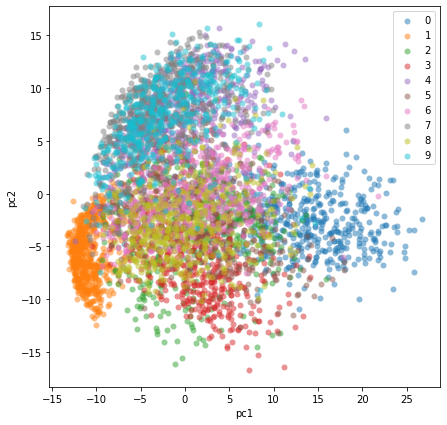

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit_transform(data.numpy())
print(pca.shape)
targets = mnist.targets.numpy()[:5000]
plt.figure(figsize=(7, 7))
for class_idx in range(10):
    idxs = np.argwhere(targets == class_idx)
    plt.scatter(*pca[idxs].T, label=class_idx, lw=0, alpha=0.5)
plt.legend()
plt.xlabel('pc1')
plt.ylabel('pc2')
plt.show()

# Now, let's train a VAE.  
For simplicity, here only the mean of the latent encoding is estimated (fixed, diagonal variance matrix).


In [ ]:
def train_vae(beta=1e-3, lr=1e-4, epochs=20, sigma=1.):
    encoder = nn.Sequential(
        nn.Linear(28 * 28, 1024), nn.ReLU(), nn.BatchNorm1d(1024),
        nn.Linear(1024, 256), nn.ReLU(), nn.BatchNorm1d(256),
        nn.Linear(256, 2)  # two dimensional latent space
    ).cuda()
    decoder = nn.Sequential(
        nn.Linear(2, 256), nn.ReLU(), nn.BatchNorm1d(256),
        nn.Linear(256, 1024), nn.ReLU(), nn.BatchNorm1d(1024),
        nn.Linear(1024, 28 * 28),
    ).cuda()
    model = nn.Sequential(encoder, decoder)
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    pbar = tqdm(range(epochs))
    for epoch in pbar:
        model.train()
        losses = []
        for x in dataloader:
            x = x.cuda()
            h_mu = encoder(x)  # get estimated mean from encoder
            h = h_mu + torch.randn_like(h_mu) * sigma  # sample from N(h_mu, diag(2)*sigma)
            x_hat = decoder(h)  # reconstruct x from sampled latent encoding
            reconstruction_loss = F.mse_loss(x, x_hat)
            latent_distribution_loss = (h_mu ** 2).mean()
            loss = reconstruction_loss + beta * latent_distribution_loss

            opt.zero_grad()
            loss.backward()
            opt.step()

            losses.append(loss.item())
        train_losses.append(np.mean(losses))
        pbar.set_description(f'mse loss: {train_losses[-1]:.4f}')

    model.eval()
    return encoder, decoder

## Visualize latent space

In [ ]:
def visualize_latent_space(encoder, decoder):
    # 2d latent embeddings
    h = []
    for x in dataloader_no_shuffle:
        with torch.no_grad():
            h.append(encoder(x.cuda()).cpu())
    h = torch.cat(h)
    l = h.norm(dim=-1).median().item() * 2.2

    targets = mnist.targets.numpy()[:5000]
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(14, 7))

    for class_idx in range(10):
        idxs = np.argwhere(targets == class_idx)
        a = ax0.scatter([], [], label=class_idx)
        ax0.scatter(*h[idxs].T, lw=0, alpha=0.3, c=a.get_facecolor())

    ax0.set_xlim(-l, l)
    ax0.set_ylim(-l, l)
    ax0.legend()
    ax0.grid()
    ax0.set_title('MNIST latent embeddings')

    # reconstruction over the 2d latent space
    n = 20
    l_ = l - l / n
    h0, h1 = np.meshgrid(np.linspace(-l_, l_, n), -np.linspace(-l_, l_, n))
    h = np.stack((h0, h1), axis=-1).reshape(n * n, 2)
    with torch.no_grad():
        imgs = (decoder(torch.from_numpy(h).float().cuda()) * std + mu).cpu().numpy()
    imgs = np.clip(imgs.reshape((n, n, 28, 28)), 0, 1)
    imgs = np.concatenate(imgs, axis=1) # (n, 28*n, 28)
    imgs = np.concatenate(imgs, axis=1) # (28*n, 28*n)
    ax1.imshow(imgs, cmap='gray', extent=(-l, l, -l, l))
    ax1.set_title('Latent space reconstructions')

    plt.tight_layout()
    plt.show()

  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


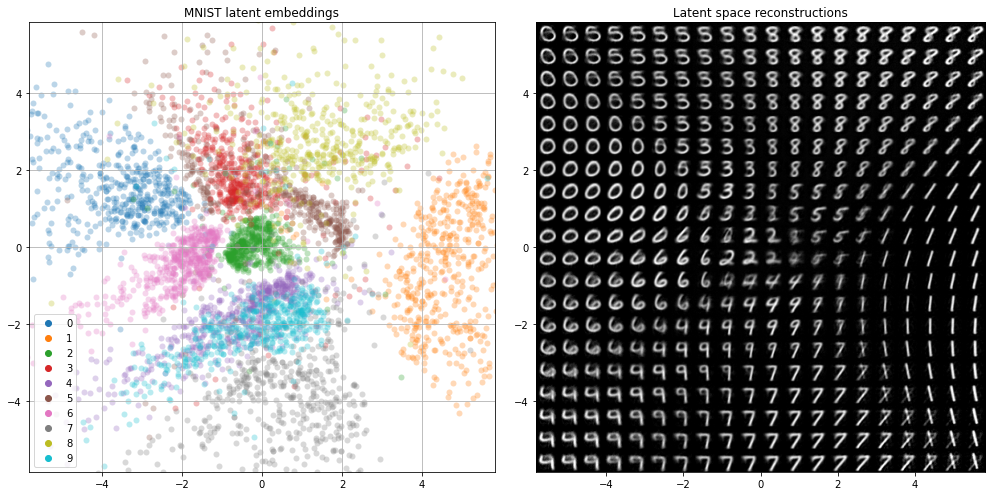

In [ ]:
# no latent space prior, no sampling (Standard AE - not VAE)
visualize_latent_space(*train_vae(beta=0, sigma=0))

  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


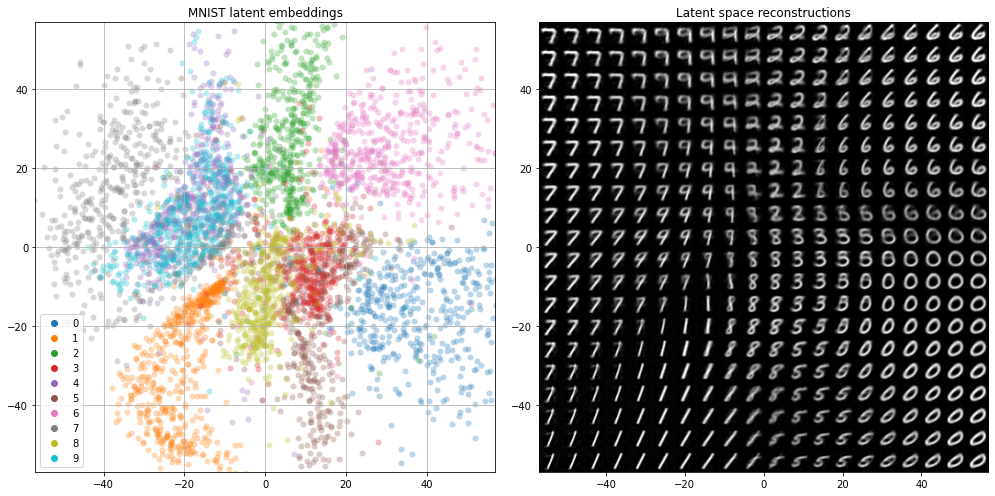

In [ ]:
visualize_latent_space(*train_vae(beta=0, sigma=1)) # no latent space prior, but sampling

  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


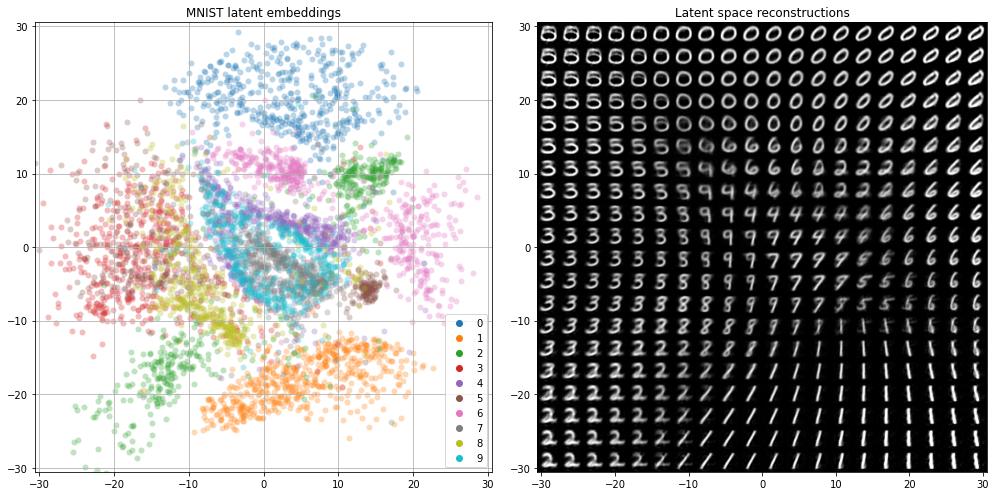

In [ ]:
visualize_latent_space(*train_vae(beta=1e-4, sigma=1))

  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


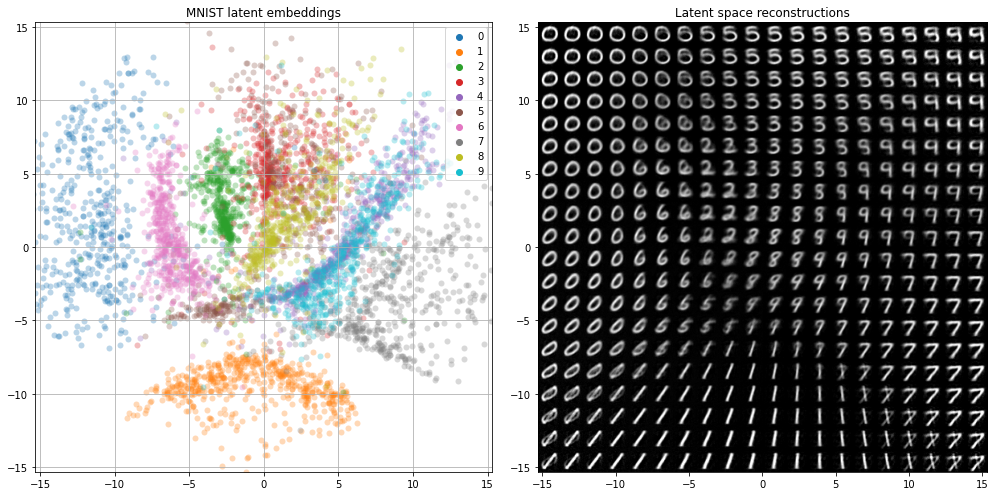

In [ ]:
visualize_latent_space(*train_vae(beta=1e-3, sigma=1))

  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


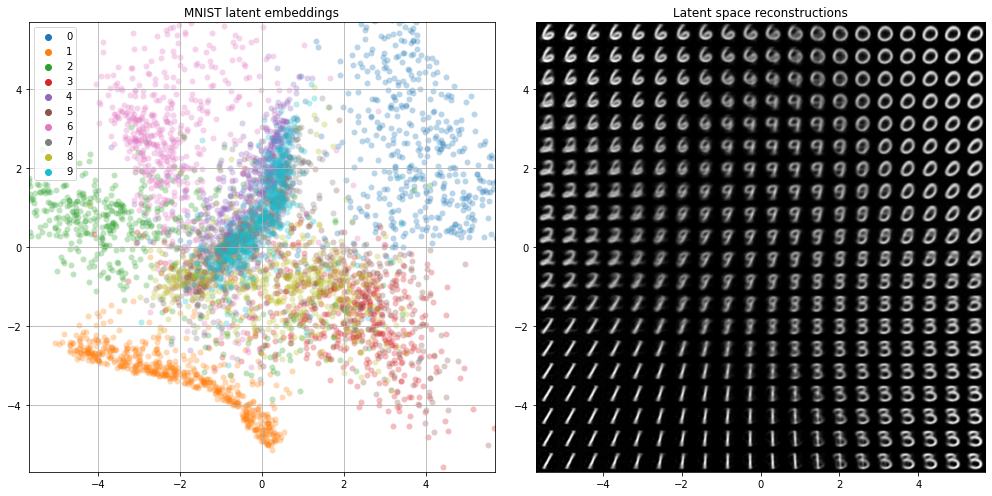

In [ ]:
visualize_latent_space(*train_vae(beta=1e-2, sigma=1))

  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


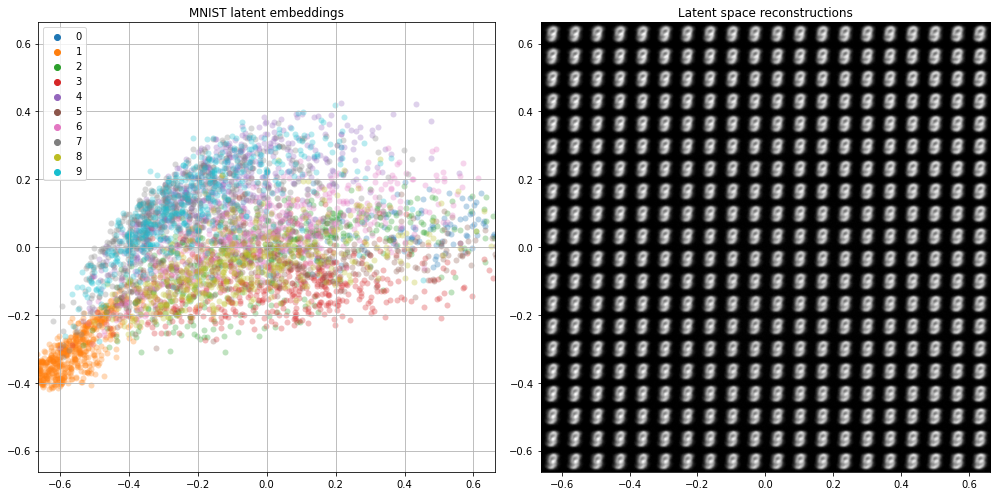

In [ ]:
visualize_latent_space(*train_vae(beta=1e-1, sigma=1))  # too strict latent prior
# (latent prior dominates loss, reconstruction error is large)